<a href="https://colab.research.google.com/github/pranathadoddy/gender-prediction/blob/main/Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preparation

In [1]:
import os
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

import torch

In [2]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUM_EPOCHS = 25

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dfGender = pd.read_csv('/content/drive/MyDrive/DataCelebA/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
dfGender.loc[dfGender['Male'] == -1, 'Male'] = 0
dfGender.head()

Male
000001.jpg     0
000002.jpg     0
000003.jpg     1
000004.jpg     0
000005.jpg     0

In [5]:
filenames = os.listdir("/content/drive/MyDrive/Images/")
dfGender = dfGender[dfGender.index.isin(filenames)]


dfGender.head()

Male
000051.jpg     1
000052.jpg     1
000065.jpg     1
000166.jpg     1
000198.jpg     0

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


Text(0.5, 1.0, '(218, 178, 3)')

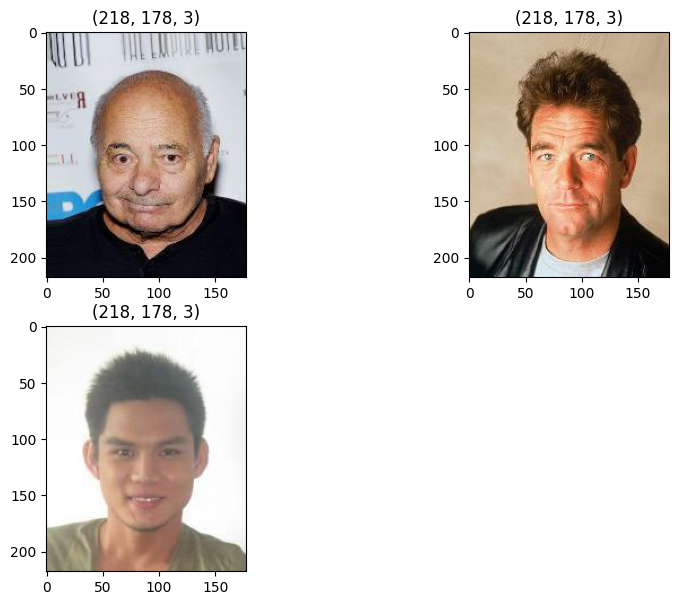

In [6]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(2, 2, 1)

img1 = Image.open('/content/drive/MyDrive/Images/000051.jpg')
print(np.asarray(img1, dtype=np.uint8).shape)
plt.imshow(img1);
plt.title(np.asarray(img1, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 2)

img2 = Image.open('/content/drive/MyDrive/Images/000052.jpg')
print(np.asarray(img2, dtype=np.uint8).shape)
plt.imshow(img2);
plt.title(np.asarray(img2, dtype=np.uint8).shape)

fig.add_subplot(2, 2, 3)

img3 = Image.open('/content/drive/MyDrive/Images/000065.jpg')
print(np.asarray(img3, dtype=np.uint8).shape)
plt.imshow(img3);
plt.title(np.asarray(img3, dtype=np.uint8).shape)

In [7]:
dfPartition = pd.read_csv('/content/drive/MyDrive/DataCelebA/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
dfPartition.columns = ['Filename', 'Partition']
dfPartition = dfPartition.set_index('Filename')

dfPartition = dfPartition[dfPartition.index.isin(filenames)]
dfPartition.head()

Partition
Filename             
000051.jpg          0
000052.jpg          0
000065.jpg          0
000166.jpg          0
000198.jpg          0

In [8]:
dfGenderPartition = dfGender.merge(dfPartition, left_index=True, right_index=True)
dfGenderPartition.head()

Male  Partition
000051.jpg     1          0
000052.jpg     1          0
000065.jpg     1          0
000166.jpg     1          0
000198.jpg     0          0

In [9]:
dfGenderPartition.loc[dfGenderPartition['Partition'] == 0].to_csv('gender_train.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 1].to_csv('gender_valid.csv')
dfGenderPartition.loc[dfGenderPartition['Partition'] == 2].to_csv('gender_test.csv')



# Data Loader

In [10]:

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

In [11]:
class ImageGenderDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [12]:


custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       transforms.ToTensor()])


train_dataset = ImageGenderDataset(csv_path='gender_train.csv',
                              img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)

valid_dataset = ImageGenderDataset(csv_path='gender_valid.csv',
                              img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)

test_dataset = ImageGenderDataset(csv_path='gender_test.csv',
                             img_dir='/content/drive/MyDrive/Images/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=496,
                         shuffle=False,
                         num_workers=4)

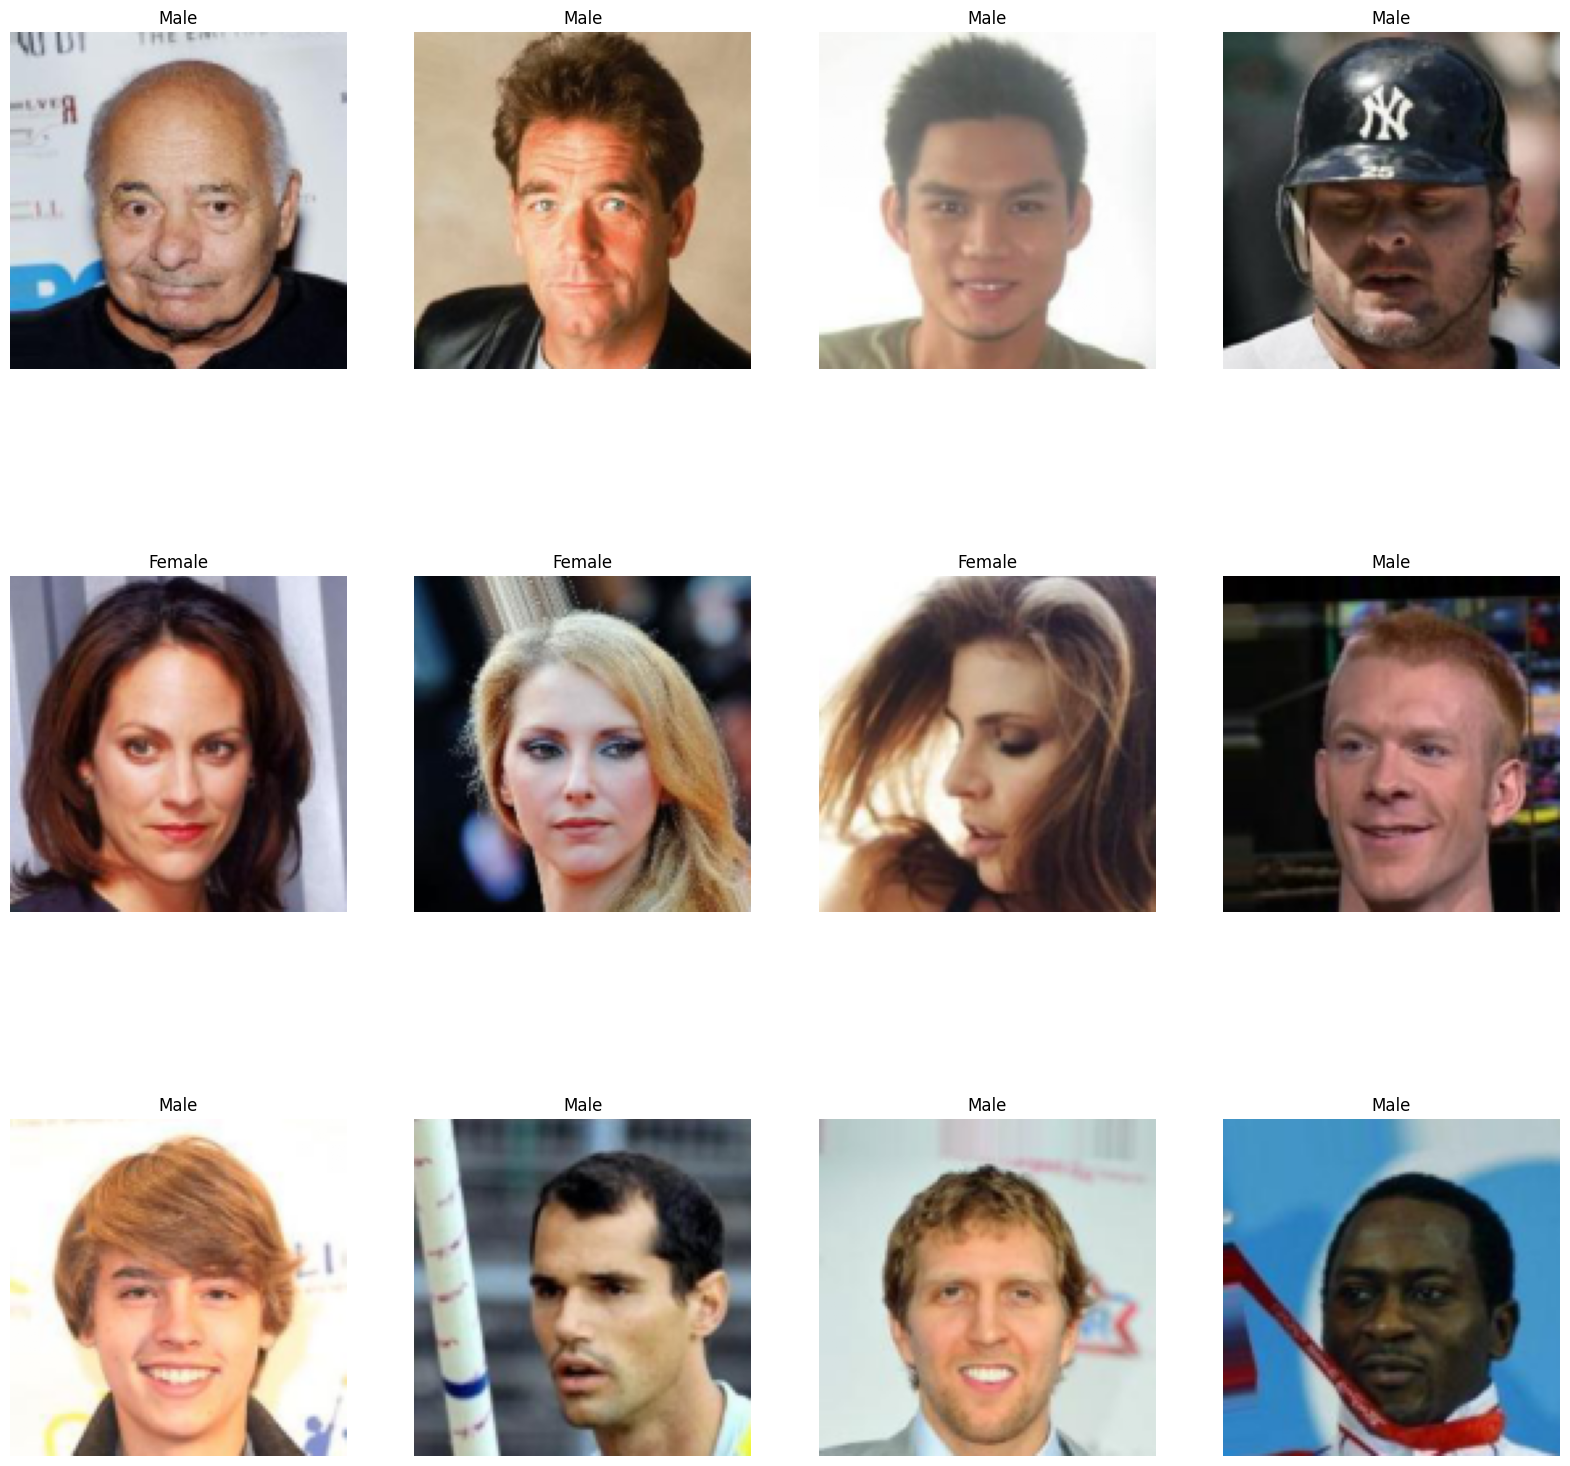

In [13]:
fig = plt.figure(figsize=(20,20))

for i, train in enumerate(train_dataset):

    fig.add_subplot(3, 4, i + 1)

    gender =  "Male" if train[1] == 1 else "Female"
    plt.title(gender)
    plt.axis('off')

    plt.imshow(np.transpose(train[0], (1, 2, 0)))

    if i == 11:
        plt.show()
        break

# Training

In [14]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html

In [15]:
import math
from torchsummary import summary

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        for m in self.modules():
                if isinstance(m, torch.nn.Conv2d):
                    m.weight.detach().normal_(0, 0.05)
                    if m.bias is not None:
                        m.bias.detach().zero_()
                elif isinstance(m, torch.nn.Linear):
                    m.weight.detach().normal_(0, 0.05)
                    m.bias.detach().detach().zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512*4*4)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas




def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, stride=1, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

def vgg16(num_classes = 2):

    model = VGG(make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']), num_classes=num_classes)

    return model


In [16]:
torch.manual_seed(1)

model = vgg16(num_classes=2)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

summary(model, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [37]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

for epoch in range(NUM_EPOCHS):
    step_loss = []
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()
        step_loss.append(cost.item())

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))
    print("Train Loss: {}".format(np.array(step_loss).mean()))
    trainingEpoch_loss.append(np.array(step_loss).mean())

    model.eval()
    validationStep_loss = []
    for batch_idx, (features, targets) in enumerate(valid_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()
        validationStep_loss.append(cost.item())
    print("Validation Loss: {}".format(np.array(validationStep_loss).mean()))
    validationEpoch_loss.append(np.array(validationStep_loss).mean())

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)
        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

Epoch: 001/025 | Batch 0000/0041 | Cost: 0.0467
Epoch: 001/025 | Batch 0005/0041 | Cost: 0.1349
Epoch: 001/025 | Batch 0010/0041 | Cost: 0.0248
Epoch: 001/025 | Batch 0015/0041 | Cost: 0.0349
Epoch: 001/025 | Batch 0020/0041 | Cost: 0.0190
Epoch: 001/025 | Batch 0025/0041 | Cost: 0.0650
Epoch: 001/025 | Batch 0030/0041 | Cost: 0.1147
Epoch: 001/025 | Batch 0035/0041 | Cost: 0.0690
Epoch: 001/025 | Batch 0040/0041 | Cost: 0.0059
Train Loss: 0.06939499002949494
Validation Loss: 0.038304364681243895
Epoch: 1 | Train: 98.43438720703125 | Valid: 100.0
Epoch: 002/025 | Batch 0000/0041 | Cost: 0.0704
Epoch: 002/025 | Batch 0005/0041 | Cost: 0.1051
Epoch: 002/025 | Batch 0010/0041 | Cost: 0.1476
Epoch: 002/025 | Batch 0015/0041 | Cost: 0.0163
Epoch: 002/025 | Batch 0020/0041 | Cost: 0.0783
Epoch: 002/025 | Batch 0025/0041 | Cost: 0.0215
Epoch: 002/025 | Batch 0030/0041 | Cost: 0.0461
Epoch: 002/025 | Batch 0035/0041 | Cost: 0.0657
Epoch: 002/025 | Batch 0040/0041 | Cost: 0.0036
Train Loss: 0.0

In [38]:
trainingEpoch_loss

[0.06939499002949494,
 0.05234505246370667,
 0.047877434783092726,
 0.049753791658298636,
 0.03670334748401329,
 0.07260356057526135,
 0.05168176596280097,
 0.034029575770368754,
 0.03918019767350903,
 0.0326208898289379,
 0.02125380481252583,
 0.030940498706668887,
 0.02565184116034155,
 0.04610155861989436,
 0.08214183088119437,
 0.042901744083614975,
 0.016345156747819403,
 0.02226051211601305,
 0.02426784570405555,
 0.01606474543471605,
 0.048950693274780015,
 0.05262662791760593,
 0.03805086333531796,
 0.021748235003409406,
 0.011530704746802236]

<function matplotlib.pyplot.show(close=None, block=None)>

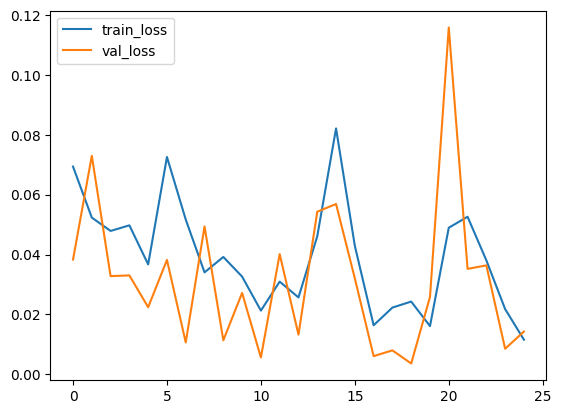

In [39]:
training_loss =  torch.tensor(trainingEpoch_loss, device = 'cpu').numpy()

validation_loss = torch.tensor(validationEpoch_loss, device = 'cpu').numpy()

plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

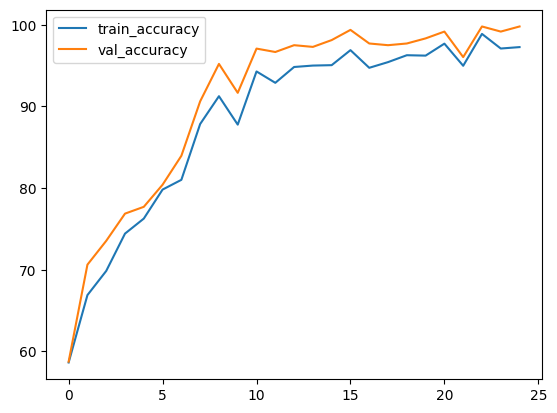

In [19]:
training_accuracy =  torch.tensor(trainingEpoch_accuracy, device = 'cpu').numpy()

validation_accuracy = torch.tensor(validationEpoch_accuracy, device = 'cpu').numpy()

plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.legend()
plt.show

# Evaluation

In [20]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Accuracy: {}'.format(compute_accuracy(model, test_loader, device=DEVICE)))

Accuracy: 93.54837799072266


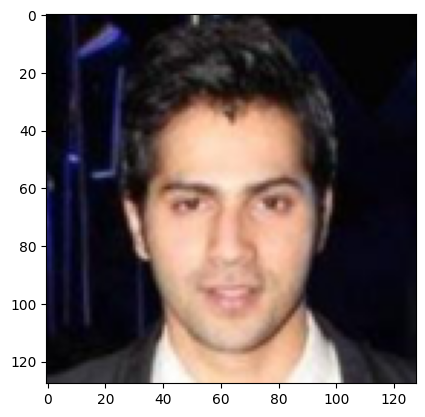

In [21]:
for index, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets

    break

plt.imshow(np.transpose(features[0], (1, 2, 0)))

In [22]:
features.to(DEVICE)[0, None].shape

torch.Size([1, 3, 128, 128])

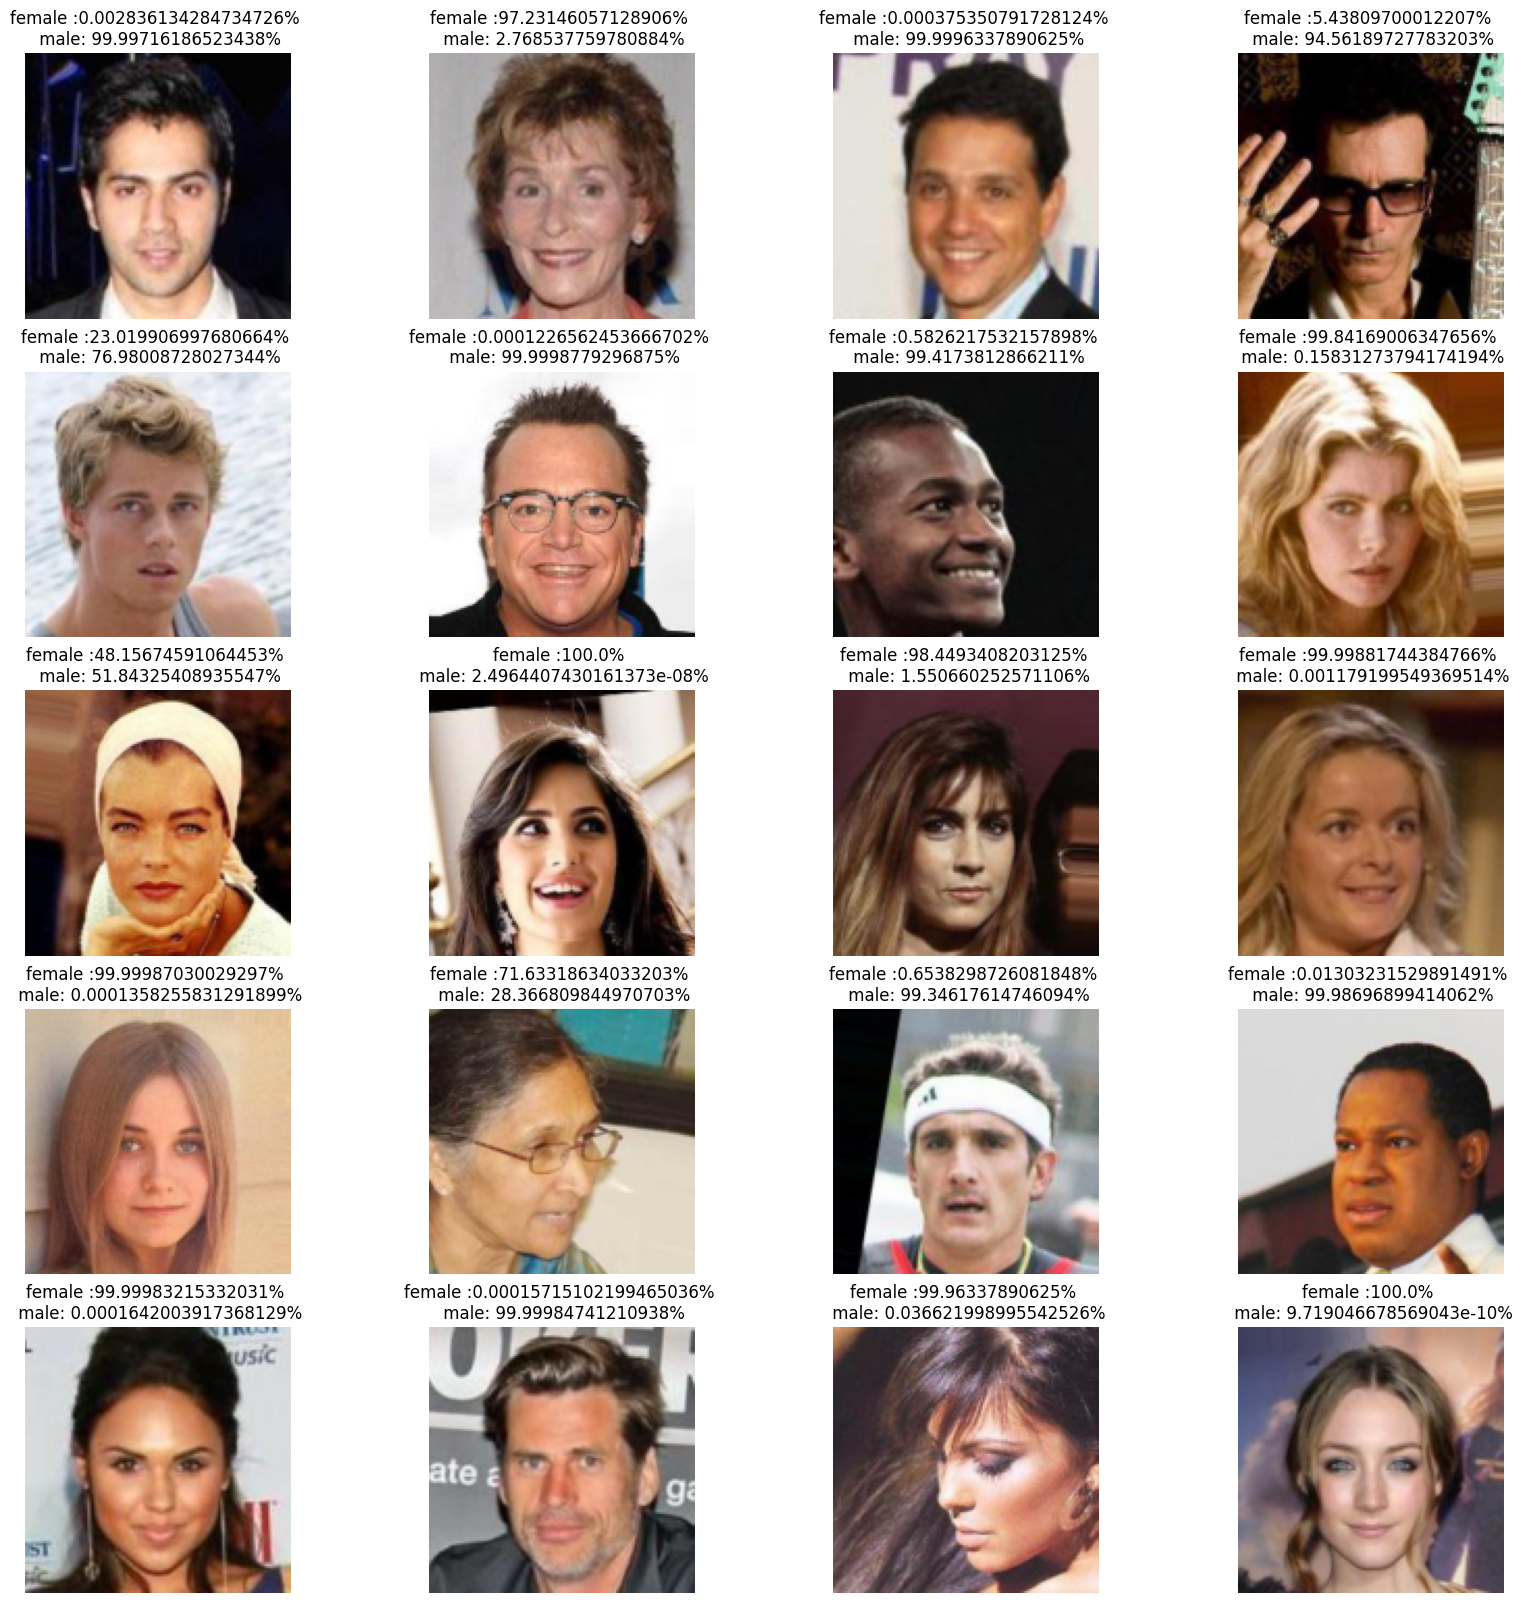

In [23]:
model.eval()

fig = plt.figure(figsize=(20,20))
for index, feature in enumerate(features):
  logits, probas = model(features[index, None].to(DEVICE))

  fig.add_subplot(5, 4, index + 1)
  plt.title('female :{}% \n male: {}%'.format(probas[0][0]*100, probas[0][1]*100))
  plt.axis('off')
  plt.imshow(np.transpose(feature, (1, 2, 0)))
  if index == 19:
    plt.show()
    break


In [24]:
predictions = []
for index, feature in enumerate(features):
  logits, probas = model(features[index, None].to(DEVICE))

  female_probas = probas[0][0]*100
  male_probas = probas[0][1]*100

  predictions.append(1 if male_probas > female_probas else 0)

In [25]:
test_targets = targets.cpu().numpy()

len(test_targets)

496

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(test_targets,predictions)
cm

array([[303,  18],
       [ 14, 161]])

Text(95.72222222222221, 0.5, 'Predicted Values')

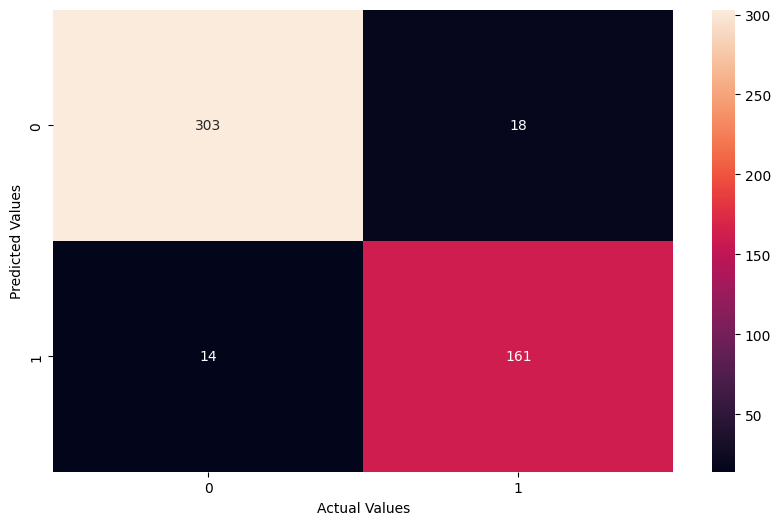

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True, fmt='g')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')